<a href="https://colab.research.google.com/github/enisbe/stock-trading-app/blob/main/model/strategy_and_backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portfolio Strategy

Portfolio Strategy using predicted prices of S&P 500 as basis. Only top 20 stocks with the highest expected return are selected in the portfolio and portfolio optimization is conducted on the selected 20 stocks. 

#Accessing Market Data  <a class="anchor" id="second-bullet"></a>

In [ ]:
%%capture
!pip install alpaca_trade_api
!pip install backtrader
!pip install matplotlib==3.2.2
!pip install plotly

In [ ]:
# Load the required modules and packages
import numpy as np
import pandas as pd
import pandas_datareader as web
#import plotly.express as px
import pandas_datareader
import datetime
import pandas_datareader.data as web
import plotly.graph_objects as go

In [ ]:
!pip install pandas numpy matplotlib yfinance PyPortfolioOpt yahooquery

In [ ]:
import pandas as pd

# There are 2 tables on the Wikipedia page
# we want the first table

payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
second_table = payload[1]

df_sp500 = first_table.convert_dtypes()
df_sp500.convert_dtypes()
df_sp500.to_csv('sp500' + '.csv', index=False)
df_sp500.info()
df_sp500.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Symbol                 504 non-null    string
 1   Security               504 non-null    string
 2   SEC filings            504 non-null    string
 3   GICS Sector            504 non-null    string
 4   GICS Sub-Industry      504 non-null    string
 5   Headquarters Location  504 non-null    string
 6   Date first added       459 non-null    string
 7   CIK                    504 non-null    Int64 
 8   Founded                504 non-null    string
dtypes: Int64(1), string(8)
memory usage: 36.1 KB


,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902


In [ ]:
import yfinance as yf

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902


In [ ]:
from yahooquery import Ticker

#mf_symbols = pd.read_excel('tickers_mutual_funds.xlsx')
symbols = sp500.Symbol.tolist()

tickers = Ticker(symbols, asynchronous=True)

data = tickers.history(period ="1d", interval="5m")

In [ ]:
for key in data:
    if isinstance(data[key], pd.DataFrame):
        data[key]['symbol'] = key

# Concat all dataframes
df = pd.concat([data[k] for k in data if isinstance(data[k], pd.DataFrame)])

In [ ]:
df.head()

In [ ]:
SPY=Ticker('SPY',asynchronous=True)
data1=SPY.history(period ="1d", interval="5m")

In [ ]:
for key in data1:
    if isinstance(data1[key], pd.DataFrame):
        data1[key]['symbol'] = key

In [ ]:
df.to_csv('all_price.csv')

In [ ]:
data1.to_csv('SPY_price.csv')

In [ ]:
df.reset_index(inplace=True)

In [ ]:
df_cleaned=df[['index','close','symbol']]

In [ ]:
df_cleaned['date']=df_cleaned['index']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
pivoted = df_cleaned.pivot(index='date', columns="symbol", values="close")

In [ ]:
pivoted2=pivoted.copy()

In [ ]:
data1.reset_index(inplace=True)

In [ ]:
df1_cleaned=data1[['date','close','symbol']]

In [ ]:
pivoted1 = df1_cleaned.pivot(index='date', columns="symbol", values="close")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


In [ ]:
import pypfopt
from pypfopt import plotting

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
%matplotlib inline
plt.close('all')


# Portfolio Strategy

## Strategy 1

### Portfolio Optimization based on max sharpe ratio

In [ ]:
import pandas as pd
from pypfopt import EfficientFrontier, objective_functions
from pypfopt import risk_models
from pypfopt import expected_returns  
import cvxpy as cp
# Read in price data
#df=pd.read_csv('all_price_close.csv',index_col="Date")
# Calculate expected returns and covariance
all=pivoted.copy()
mu = expected_returns.mean_historical_return(pivoted, frequency=len(pivoted.index))
mu1 = mu.sort_values(ascending=False).head(20)
df_S=pivoted[[x for x in mu1.index]]
S = risk_models.sample_cov(df_S,frequency=len(pivoted.index))

# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu1, S)
#ef = EfficientFrontier(mu,S1)
#ef.add_objective(objective_functions.L2_reg, gamma=1)
ef.add_constraint(lambda w: w[0]+w[1]+w[2]+w[3]+w[4]+w[5]+w[6]+w[7]
                  +w[8]+w[9]+w[10]+w[11]+w[12]+w[13]
                  +w[14]+w[15]+w[16]+w[17]+w[18]+w[19]
                  == int(1))
ef.add_constraint((lambda w: cp.sum(w) == 1))
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights(rounding=3)
ef.save_weights_to_file("weights.csv")  # saves to file
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

OrderedDict([('BMY', 1.0), ('BAX', 0.0), ('MOH', 0.0), ('ABBV', 0.0), ('HOLX', 0.0), ('CERN', 0.0), ('NLSN', 0.0), ('PTC', 0.0), ('DXCM', 0.0), ('CL', 0.0), ('HSY', 0.0), ('ABMD', 0.0), ('MRK', 0.0), ('CNC', 0.0), ('JNJ', 0.0), ('LH', 0.0), ('MTD', 0.0), ('CTLT', 0.0), ('PKG', 0.0), ('CTXS', 0.0)])
Expected annual return: 2.2%
Annual volatility: 2.2%
Sharpe Ratio: 0.11


(0.02235134130169246, 0.02208974537248421, 0.10644492555452338)

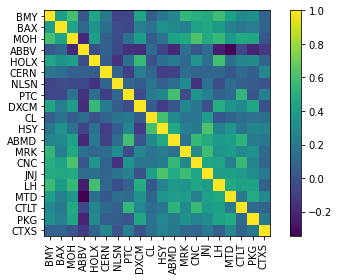

In [ ]:
plotting.plot_covariance(S, plot_correlation=True)

In [ ]:
pd.Series(cleaned_weights).plot.pie(figsize=(10, 10))

## Strategy 2

### Portfolio Optimization based on min volatility


In [ ]:
import pandas as pd
from pypfopt import EfficientFrontier, objective_functions
from pypfopt import risk_models
from pypfopt import expected_returns  

# Read in price data
#df=pd.read_csv('all_price_close.csv',index_col="Date")
# Calculate expected returns and covariance
mu2 = expected_returns.ema_historical_return(pivoted, frequency=len(pivoted.index))
mu3 = mu2.sort_values(ascending=False).head(20)
df_S2=pivoted[[x for x in mu3.index]]
S2 = risk_models.sample_cov(df_S2,frequency=len(pivoted.index))
# Optimize for maximal Sharpe ratio
ef2 = EfficientFrontier(mu3, S2)
#ef.add_objective(objective_functions.L2_reg, gamma=1)
ef2.add_constraint(lambda w: w[0]+w[1]+w[2]+w[3]+w[4]+w[5]+w[6]+w[7]
                  +w[8]+w[9]+w[10]+w[11]+w[12]+w[13]
                  +w[14]+w[15]+w[16]+w[17]+w[18]+w[19]
                  == 1)
raw_weights2 = ef2.min_volatility()
cleaned_weights2 = ef2.clean_weights()
ef2.save_weights_to_file("weights2.csv")  # saves to file
print(cleaned_weights2)
ef2.portfolio_performance(verbose=True)

OrderedDict([('BMY', 0.0), ('ABBV', 0.0), ('BAX', 0.0), ('MOH', 0.0), ('NLSN', 0.00534), ('CERN', 0.95843), ('HOLX', 0.0), ('CL', 0.0), ('PTC', 0.00437), ('MRK', 0.0), ('HSY', 0.02078), ('ABMD', 0.0), ('JNJ', 0.0), ('CNC', 0.0), ('CTXS', 0.01108), ('LH', 0.0), ('LLY', 0.0), ('PKG', 0.0), ('LDOS', 0.0), ('URI', 0.0)])
Expected annual return: -0.1%
Annual volatility: 0.2%
Sharpe Ratio: -13.04


(-0.0013094841219438139, 0.00163452076288288, -13.037144957620049)

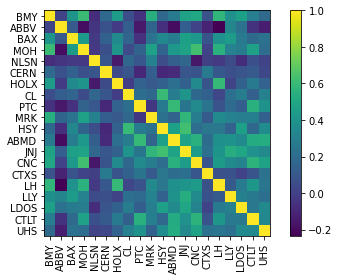

In [ ]:
plotting.plot_covariance(S2, plot_correlation=True)

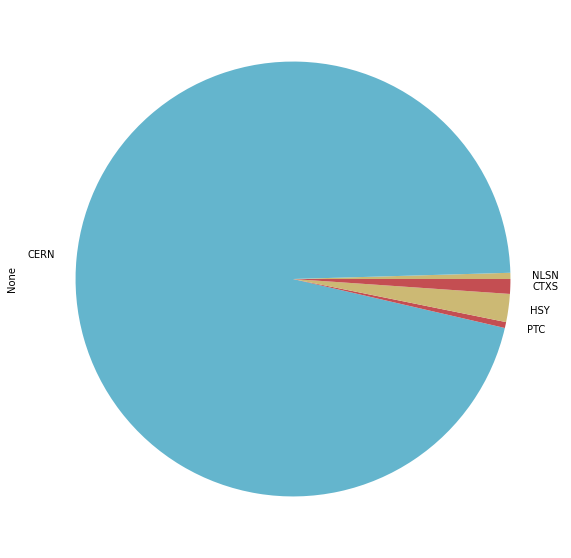

In [ ]:
pd.Series(cleaned_weights2).plot.pie(figsize=(10, 10))

## Discrete Allocation

Discrete Allocation of Portfolio Strategies.Convert optimized weight into actual allocation of stock shares available for purchase by entering the latest price and investment size.

In [ ]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
latest_prices = get_latest_prices(df_S)
weights = cleaned_weights 
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=20000)
allocation, leftover = da.lp_portfolio()
print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

In [ ]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
latest_prices = get_latest_prices(df_S2)
weights2 = cleaned_weights2
da = DiscreteAllocation(weights2, latest_prices, total_portfolio_value=20000)
allocation, leftover = da.lp_portfolio()
print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Discrete allocation: {'NLSN': 3, 'CERN': 153, 'PTC': 1, 'HSY': 1, 'CTXS': 2}
Funds remaining: $52.47


# Backtesting using portfolio-backtest

Compare performances of our own strategies with below list of available portfolios using historical data:
Hierarchical Risk Parity Portfolio

*   Tangency Portfolio
*   Minimum Variance Portfolio
*   Minimum CVaR Portfolio/
*   Semi Variance Portfolio
*   Return Maximize CVaR Portfolio




In [ ]:
pip install portfolio-backtest

In [ ]:
strategy1=dict(cleaned_weights)
strategy2=dict(cleaned_weights2)

In [ ]:
weight1=pd.DataFrame(strategy1.items(), columns=['ticker','weight'])
weight2=pd.DataFrame(strategy2.items(), columns=['ticker','weight'])

In [ ]:
s1=sum(weight1.weight)

In [ ]:
weight1.weight=weight1.weight/s1

In [ ]:
s2=sum(weight2.weight)

In [ ]:
weight2.weight=weight2.weight/s2

In [ ]:
weight1.set_index('ticker')

In [ ]:
weight2.set_index('ticker')

In [ ]:
strategy_nor1=dict(zip(weight1.ticker, weight1.weight))

In [ ]:
strategy_nor2=dict(zip(weight2.ticker, weight2.weight))

In [ ]:
from portfolio_backtest import Backtest
import pprint

bt = Backtest(
    tickers=strategy_nor1,
    target_return=0.1,
    target_cvar=0.025,
    data_dir="data",
    start="2021-04-10",
    end="2022-04-10",
)
stats1=bt.run(plot=False)
#pprint.pprint(bt.run(plot=False))

[*********************100%***********************]  20 of 20 completed


In [ ]:
bt1=pd.DataFrame(stats1).style.set_properties(subset=['tickers'], **{'width': '1000px'})

In [ ]:
bt1

,portfolio,tickers,Expected annual return,Annual volatility,Sharpe Ratio,Conditional Value at Risk,Cumulative Return
0,Your Portfolio,"{'ABBV': 0.0, 'ABMD': 0.0, 'BAX': 0.0, 'BMY': 1.0, 'CERN': 0.0, 'CL': 0.0, 'CNC': 0.0, 'CTLT': 0.0, 'CTXS': 0.0, 'DXCM': 0.0, 'HOLX': 0.0, 'HSY': 0.0, 'JNJ': 0.0, 'LH': 0.0, 'MOH': 0.0, 'MRK': 0.0, 'MTD': 0.0, 'NLSN': 0.0, 'PKG': 0.0, 'PTC': 0.0}",28.0%,19.3%,1.35,,28.0%
1,Tangency Portfolio,"{'ABBV': 0.53799, 'ABMD': 0.0, 'BAX': 0.0, 'BMY': 0.0, 'CERN': 0.09056, 'CL': 0.0, 'CNC': 0.0166, 'CTLT': 0.0, 'CTXS': 0.0, 'DXCM': 0.05213, 'HOLX': 0.0, 'HSY': 0.30272, 'JNJ': 0.0, 'LH': 0.0, 'MOH': 0.0, 'MRK': 0.0, 'MTD': 0.0, 'NLSN': 0.0, 'PKG': 0.0, 'PTC': 0.0}",55.1%,13.7%,3.87,,55.9%
2,Minimum Variance Portfolio,"{'ABBV': 0.05547, 'ABMD': 0.01841, 'BAX': 0.0271, 'BMY': 0.04154, 'CERN': 0.14613, 'CL': 0.09836, 'CNC': 0.0, 'CTLT': 0.00817, 'CTXS': 0.04809, 'DXCM': 0.00567, 'HOLX': 0.06931, 'HSY': 0.14981, 'JNJ': 0.13341, 'LH': 0.01321, 'MOH': 0.0, 'MRK': 0.05549, 'MTD': 0.01972, 'NLSN': 0.00392, 'PKG': 0.08883, 'PTC': 0.01737}",19.5%,10.2%,1.72,,19.5%
3,Hierarchical Risk Parity Portfolio,"{'ABBV': 0.07703, 'ABMD': 0.00818, 'BAX': 0.06859, 'BMY': 0.07817, 'CERN': 0.10304, 'CL': 0.05562, 'CNC': 0.03814, 'CTLT': 0.02345, 'CTXS': 0.03883, 'DXCM': 0.00699, 'HOLX': 0.04839, 'HSY': 0.06102, 'JNJ': 0.10691, 'LH': 0.05801, 'MOH': 0.03853, 'MRK': 0.04954, 'MTD': 0.02955, 'NLSN': 0.01866, 'PKG': 0.07098, 'PTC': 0.02035}",18.9%,11.1%,1.52,,20.1%
4,Minimum CVaR Portfolio,"{'ABBV': 0.01566, 'ABMD': 0.0, 'BAX': 0.0, 'BMY': 0.0598, 'CERN': 0.1934, 'CL': 0.16649, 'CNC': 0.0, 'CTLT': 0.0, 'CTXS': 0.0, 'DXCM': 0.01601, 'HOLX': 0.09716, 'HSY': 0.07197, 'JNJ': 0.06744, 'LH': 0.0, 'MOH': 0.0, 'MRK': 0.09856, 'MTD': 0.02823, 'NLSN': 0.00928, 'PKG': 0.13134, 'PTC': 0.04466}",17.4%,,,1.2%,18.2%
5,Semi Variance Portfolio (target return 10.0%),"{'ABBV': 0.11494, 'ABMD': 0.00985, 'BAX': 0.0, 'BMY': 0.04436, 'CERN': 0.1809, 'CL': 0.00843, 'CNC': 0.0, 'CTLT': 0.0, 'CTXS': 0.01108, 'DXCM': 0.01596, 'HOLX': 0.07262, 'HSY': 0.16331, 'JNJ': 0.16995, 'LH': 0.0, 'MOH': 0.0, 'MRK': 0.07466, 'MTD': 0.01691, 'NLSN': 0.0, 'PKG': 0.11259, 'PTC': 0.00444}",28.1%,6.5%,4.05,,28.6%
6,Return Maximize CVaR Portfolio (target CVaR 2.5%),"{'ABBV': 1.0, 'ABMD': 0.0, 'BAX': 0.0, 'BMY': 0.0, 'CERN': 0.0, 'CL': 0.0, 'CNC': 0.0, 'CTLT': 0.0, 'CTXS': 0.0, 'DXCM': 0.0, 'HOLX': 0.0, 'HSY': 0.0, 'JNJ': 0.0, 'LH': 0.0, 'MOH': 0.0, 'MRK': 0.0, 'MTD': 0.0, 'NLSN': 0.0, 'PKG': 0.0, 'PTC': 0.0}",69.2%,,,2.5%,69.2%


In [ ]:
from portfolio_backtest import Backtest
import pprint

bt = Backtest(
    tickers=strategy_nor2,
    target_return=0.1,
    target_cvar=0.025,
    data_dir="data",
    start="2021-04-10",
    end="2022-04-10",
)
stats2=bt.run(plot=False)
#pprint.pprint(bt.run(plot=False))

[*********************100%***********************]  20 of 20 completed


In [ ]:
bt2=pd.DataFrame(stats2).style.set_properties(subset=['tickers'], **{'width': '1000px'})

In [ ]:
bt2

,portfolio,tickers,Expected annual return,Annual volatility,Sharpe Ratio,Conditional Value at Risk,Cumulative Return
0,Your Portfolio,"{'ABBV': 0.0, 'ABMD': 0.0, 'BAX': 0.0, 'BMY': 0.0, 'CERN': 0.95843, 'CL': 0.0, 'CNC': 0.0, 'CTLT': 0.0, 'CTXS': 0.01108, 'HOLX': 0.0, 'HSY': 0.02078, 'JNJ': 0.0, 'LDOS': 0.0, 'LH': 0.0, 'LLY': 0.0, 'MOH': 0.0, 'MRK': 0.0, 'NLSN': 0.00534, 'PKG': 0.0, 'PTC': 0.00437}",27.8%,20.5%,1.26,,27.7%
1,Tangency Portfolio,"{'ABBV': 0.4276, 'ABMD': 0.0, 'BAX': 0.0, 'BMY': 0.0, 'CERN': 0.11569, 'CL': 0.0, 'CNC': 0.01396, 'CTLT': 0.0, 'CTXS': 0.0, 'HOLX': 0.0, 'HSY': 0.25342, 'JNJ': 0.0, 'LDOS': 0.0, 'LH': 0.0, 'LLY': 0.18933, 'MOH': 0.0, 'MRK': 0.0, 'NLSN': 0.0, 'PKG': 0.0, 'PTC': 0.0}",58.3%,13.9%,4.06,,59.2%
2,Minimum Variance Portfolio,"{'ABBV': 0.05596, 'ABMD': 0.01694, 'BAX': 0.02484, 'BMY': 0.04621, 'CERN': 0.13626, 'CL': 0.08924, 'CNC': 0.0, 'CTLT': 0.01098, 'CTXS': 0.03903, 'HOLX': 0.07296, 'HSY': 0.12612, 'JNJ': 0.1166, 'LDOS': 0.08535, 'LH': 0.0187, 'LLY': 0.00096, 'MOH': 0.0, 'MRK': 0.05335, 'NLSN': 0.00263, 'PKG': 0.07971, 'PTC': 0.02417}",18.4%,9.8%,1.68,,18.6%
3,Hierarchical Risk Parity Portfolio,"{'ABBV': 0.06839, 'ABMD': 0.01884, 'BAX': 0.08614, 'BMY': 0.0694, 'CERN': 0.09773, 'CL': 0.04938, 'CNC': 0.0271, 'CTLT': 0.019, 'CTXS': 0.03657, 'HOLX': 0.04615, 'HSY': 0.05418, 'JNJ': 0.09491, 'LDOS': 0.05991, 'LH': 0.03884, 'LLY': 0.03418, 'MOH': 0.02996, 'MRK': 0.04862, 'NLSN': 0.01737, 'PKG': 0.07748, 'PTC': 0.02585}",18.6%,10.9%,1.52,,19.7%
4,Minimum CVaR Portfolio,"{'ABBV': 0.11815, 'ABMD': 0.01567, 'BAX': 0.0, 'BMY': 0.0, 'CERN': 0.25006, 'CL': 0.17721, 'CNC': 0.0, 'CTLT': 0.0, 'CTXS': 0.02927, 'HOLX': 0.07681, 'HSY': 0.0, 'JNJ': 0.05708, 'LDOS': 0.0, 'LH': 0.0, 'LLY': 0.06767, 'MOH': 0.0, 'MRK': 0.05035, 'NLSN': 0.0, 'PKG': 0.13543, 'PTC': 0.02231}",23.7%,,,1.2%,23.0%
5,Semi Variance Portfolio (target return 10.0%),"{'ABBV': 0.1044, 'ABMD': 0.01012, 'BAX': 0.0, 'BMY': 0.03806, 'CERN': 0.17488, 'CL': 0.0, 'CNC': 0.0, 'CTLT': 0.0, 'CTXS': 0.00624, 'HOLX': 0.08459, 'HSY': 0.15563, 'JNJ': 0.14028, 'LDOS': 0.05956, 'LH': 0.0, 'LLY': 0.04649, 'MOH': 0.0, 'MRK': 0.06397, 'NLSN': 0.0, 'PKG': 0.10329, 'PTC': 0.0125}",29.1%,6.4%,4.26,,29.3%
6,Return Maximize CVaR Portfolio (target CVaR 2.5%),"{'ABBV': 0.18332, 'ABMD': 0.0, 'BAX': 0.0, 'BMY': 0.0, 'CERN': 0.0, 'CL': 0.0, 'CNC': 0.0, 'CTLT': 0.0, 'CTXS': 0.0, 'HOLX': 0.0, 'HSY': 0.0, 'JNJ': 0.0, 'LDOS': 0.0, 'LH': 0.0, 'LLY': 0.81668, 'MOH': 0.0, 'MRK': 0.0, 'NLSN': 0.0, 'PKG': 0.0, 'PTC': 0.0}",73.1%,,,2.5%,74.0%


# Backtesting using Self-Designed Function

## Strategy 1

In [ ]:
#Portfolio Asset Allocation. 
labels = weight1.ticker.to_list()
allocation_pct = weight1.weight.to_list()

fig = go.Figure(data=[go.Pie(labels=labels, values=allocation_pct)])
fig.update_layout(title="Portfolio Asset Allocation")
fig.show()

In [ ]:
import yfinance as yf

In [ ]:
SPY=data1.copy()

In [ ]:
# Calculate the cumulative return
for t in labels: 
  pivoted[t+'Cum Return'] = pivoted[t]/pivoted.iloc[0][t]

In [ ]:
# Calculate value of initial investment of 10K in the Portfolio

init_investment = 20000
for t, alloc in zip(labels,allocation_pct):
  pivoted[t+'Value'] = alloc*init_investment*pivoted[t+'Cum Return']


In [ ]:
SPY['Cum Return']= SPY['close']/SPY.iloc[0]['close']

In [ ]:
# Calculate value of initial investment of 10K in the SPY
SPY['SPY Total'] = init_investment*SPY['Cum Return']
SPY['SPY Total'] = round(SPY['SPY Total'])

In [ ]:
pivoted.head()

symbol,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,HSYValue,ABMDValue,MRKValue,CNCValue,JNJValue,LHValue,MTDValue,CTLTValue,PKGValue,CTXSValue
date,,,,,,,,,,,,,,,,,,,,,
2022-04-29 09:30:00,122.000000,19.445000,208.899994,163.667999,146.380005,156.664993,287.612488,117.470001,310.894989,408.260010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-29 09:35:00,122.190002,19.459999,208.850006,163.437103,144.904999,155.970001,285.154999,117.099899,311.390015,409.001892,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-29 09:40:00,121.989998,19.301100,208.350006,162.630005,144.837601,155.770004,285.200012,116.720001,310.355011,408.170013,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0
2022-04-29 09:45:00,122.504997,19.350000,208.167206,163.740005,140.889999,156.050003,288.820007,116.730003,309.880005,409.540009,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-29 09:50:00,122.889999,19.360001,208.304993,164.244003,141.419998,155.789993,289.369995,117.190002,309.265015,410.570007,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0


In [ ]:
# Combine All values
all_vals =[pivoted[t+'Value'] for t in labels]
portfolio_val = pd.concat(all_vals, axis=1)
portfolio_val.columns = labels

In [ ]:
# Calculate Cumulative Return and Cumulative Return %
portfolio_val['Portfolio Total'] = round(portfolio_val.sum(axis=1))
portfolio_val['Cum Return'] = portfolio_val['Portfolio Total']/portfolio_val.iloc[0]['Portfolio Total']

In [ ]:
portfolio_val['Cum Return %'] = (portfolio_val['Cum Return'] - 1) * 100
SPY['Cum Return %'] = (SPY['Cum Return'] - 1) * 100
SPY.tail()

,symbol,date,close,volume,open,high,low,Cum Return,SPY Total,Cum Return %
74,SPY,2022-04-29 15:40:00,414.079987,2830363,414.614990,415.149994,414.010010,0.975584,19512.0,-2.441554
75,SPY,2022-04-29 15:45:00,412.839996,5219374,414.059998,414.269989,412.760010,0.972663,19453.0,-2.733700
76,SPY,2022-04-29 15:50:00,411.869995,8360271,412.839996,412.839996,411.510010,0.970378,19408.0,-2.962235
77,SPY,2022-04-29 15:55:00,412.019989,13940810,411.859985,412.450012,411.209991,0.970731,19415.0,-2.926896
78,SPY,2022-04-29 16:00:00,412.000000,0,412.000000,412.000000,412.000000,0.970684,19414.0,-2.931605


In [ ]:
SPY.reset_index()

,index,symbol,date,close,volume,open,high,low,Cum Return,SPY Total,Cum Return %
0,0,SPY,2022-04-29 09:30:00,424.442993,4306819,423.589996,424.670013,422.679993,1.000000,20000.0,0.000000
1,1,SPY,2022-04-29 09:35:00,423.829987,1558077,424.450012,424.880005,423.309998,0.998556,19971.0,-0.144426
2,2,SPY,2022-04-29 09:40:00,422.859985,1220415,423.820007,424.220001,422.690002,0.996270,19925.0,-0.372961
3,3,SPY,2022-04-29 09:45:00,423.380005,1143666,422.869995,423.660004,422.575012,0.997496,19950.0,-0.250443
4,4,SPY,2022-04-29 09:50:00,423.555603,1054068,423.320007,424.000000,422.929993,0.997909,19958.0,-0.209072
...,...,...,...,...,...,...,...,...,...,...,...
74,74,SPY,2022-04-29 15:40:00,414.079987,2830363,414.614990,415.149994,414.010010,0.975584,19512.0,-2.441554
75,75,SPY,2022-04-29 15:45:00,412.839996,5219374,414.059998,414.269989,412.760010,0.972663,19453.0,-2.733700
76,76,SPY,2022-04-29 15:50:00,411.869995,8360271,412.839996,412.839996,411.510010,0.970378,19408.0,-2.962235
77,77,SPY,2022-04-29 15:55:00,412.019989,13940810,411.859985,412.450012,411.209991,0.970731,19415.0,-2.926896


In [ ]:
# Visualize Portfolio Value and Compare it to SPY benchmark
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=portfolio_val.index, y=portfolio_val['Portfolio Total'], name='Portfolio Total'))
fig.add_trace(go.Scatter(x=SPY.date, y=SPY['SPY Total'],name='SPY Total'))
fig.update_layout(title="Portfolio Value")

In [ ]:
# Visualize Return %
fig = go.Figure()
fig.add_trace(go.Scatter(x=portfolio_val.index, y= portfolio_val['Cum Return %'], name='Portfolio Cumulative Return %'))
fig.add_trace(go.Scatter(x=SPY.date, y=SPY['Cum Return %'],name='SPY Cumulative Return %'))
fig.update_layout(title="Cumulative Return % (Portfolio vs SPY)")

In [ ]:
d1=portfolio_val['Portfolio Total'].reset_index()

In [ ]:
d2=SPY[['date','SPY Total']]

In [ ]:
d1['date'] = pd.to_datetime(d1['date'], errors='coerce')

In [ ]:
d2['date'] = pd.to_datetime(d2['date'], errors='coerce')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
print("Portfolio Correlation with SPY")
round(d1['Portfolio Total'].corr(d2['SPY Total']),2)

Portfolio Correlation with SPY


-0.21

In [ ]:
portfolio_val

In [ ]:
# Visualize Value of Individual Stocks
fig = go.Figure()
fig.add_trace(go.Scatter(x=portfolio_val.index, y= portfolio_val['BMY'], name='BMY'))


## Strategy 2

In [ ]:
#Portfolio Asset Allocation. 
labels2 = weight2.ticker.to_list()
allocation_pct2 = weight2.weight.to_list()

fig = go.Figure(data=[go.Pie(labels=labels2, values=allocation_pct2)])
fig.update_layout(title="Portfolio Asset Allocation-Strategy 2")
fig.show()

In [ ]:
import yfinance as yf

In [ ]:
pivoted2

In [ ]:
# Calculate the cumulative return
for t in labels2: 
  pivoted2[t+'Cum Return'] = pivoted2[t]/pivoted2.iloc[0][t]

In [ ]:
# Calculate value of initial investment of 20K in the Portfolio

init_investment = 20000
for t, alloc in zip(labels2,allocation_pct2):
  pivoted2[t+'Value'] = alloc*init_investment*pivoted2[t+'Cum Return']


In [ ]:
SPY['Cum Return']= SPY['close']/SPY.iloc[0]['close']

In [ ]:
# Calculate value of initial investment of 10K in the SPY
SPY['SPY Total'] = init_investment*SPY['Cum Return']
SPY['SPY Total'] = round(SPY['SPY Total'])

In [ ]:
pivoted2.head()

symbol,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,HSYValue,ABMDValue,JNJValue,CNCValue,CTXSValue,LHValue,LLYValue,PKGValue,LDOSValue,CTLTValue
date,,,,,,,,,,,,,,,,,,,,,
2022-04-29 09:30:00,122.000000,19.445000,208.899994,163.667999,146.380005,156.664993,287.612488,117.470001,310.894989,408.260010,...,415.600000,0.0,0.0,0.0,221.600000,0.0,0.0,0.0,0.0,0.0
2022-04-29 09:35:00,122.190002,19.459999,208.850006,163.437103,144.904999,155.970001,285.154999,117.099899,311.390015,409.001892,...,414.627602,0.0,0.0,0.0,221.479081,0.0,0.0,0.0,0.0,0.0
2022-04-29 09:40:00,121.989998,19.301100,208.350006,162.630005,144.837601,155.770004,285.200012,116.720001,310.355011,408.170013,...,414.600083,0.0,0.0,0.0,221.468094,0.0,0.0,0.0,0.0,0.0
2022-04-29 09:45:00,122.504997,19.350000,208.167206,163.740005,140.889999,156.050003,288.820007,116.730003,309.880005,409.540009,...,416.168758,0.0,0.0,0.0,221.542836,0.0,0.0,0.0,0.0,0.0
2022-04-29 09:50:00,122.889999,19.360001,208.304993,164.244003,141.419998,155.789993,289.369995,117.190002,309.265015,410.570007,...,414.306521,0.0,0.0,0.0,221.457107,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Combine All values
all_vals2 =[pivoted2[t+'Value'] for t in labels2]
portfolio_val2 = pd.concat(all_vals2, axis=1)
portfolio_val2.columns = labels2

In [ ]:
# Calculate Cumulative Return and Cumulative Return %
portfolio_val2['Portfolio2 Total'] = round(portfolio_val2.sum(axis=1))
portfolio_val2['Cum Return2'] = portfolio_val2['Portfolio2 Total']/portfolio_val2.iloc[0]['Portfolio2 Total']

In [ ]:
portfolio_val2['Cum Return2 %'] = (portfolio_val2['Cum Return2'] - 1) * 100
#SPY['Cum Return %'] = (SPY['Cum Return'] - 1) * 100
#SPY.tail()

In [ ]:
SPY.reset_index()

,index,symbol,date,high,volume,low,open,close,Cum Return,SPY Total,Cum Return %
0,0,SPY,2022-04-29 09:30:00,424.670013,4306819,422.679993,423.589996,424.442993,1.000000,20000.0,0.000000
1,1,SPY,2022-04-29 09:35:00,424.880005,1558077,423.309998,424.450012,423.829987,0.998556,19971.0,-0.144426
2,2,SPY,2022-04-29 09:40:00,424.220001,1220415,422.690002,423.820007,422.859985,0.996270,19925.0,-0.372961
3,3,SPY,2022-04-29 09:45:00,423.660004,1143666,422.575012,422.869995,423.380005,0.997496,19950.0,-0.250443
4,4,SPY,2022-04-29 09:50:00,424.000000,1054068,422.929993,423.320007,423.555603,0.997909,19958.0,-0.209072
...,...,...,...,...,...,...,...,...,...,...,...
74,74,SPY,2022-04-29 15:40:00,415.149994,2830363,414.010010,414.614990,414.079987,0.975584,19512.0,-2.441554
75,75,SPY,2022-04-29 15:45:00,414.269989,5219374,412.760010,414.059998,412.839996,0.972663,19453.0,-2.733700
76,76,SPY,2022-04-29 15:50:00,412.839996,8360271,411.510010,412.839996,411.869995,0.970378,19408.0,-2.962235
77,77,SPY,2022-04-29 15:55:00,412.450012,13940810,411.209991,411.859985,412.019989,0.970731,19415.0,-2.926896


In [ ]:
# Visualize Portfolio Value and Compare it to SPY benchmark
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=portfolio_val2.index, y=portfolio_val2['Portfolio2 Total'], name='Portfolio2 Total'))
fig.add_trace(go.Scatter(x=SPY.date, y=SPY['SPY Total'],name='SPY Total'))
fig.update_layout(title="Portfolio2 Value")

In [ ]:
# Visualize Return %
fig = go.Figure()
fig.add_trace(go.Scatter(x=portfolio_val.index, y= portfolio_val['Cum Return %'], name='Portfolio Cumulative Return %'))
fig.add_trace(go.Scatter(x=SPY.date, y=SPY['Cum Return %'],name='SPY Cumulative Return %'))
fig.update_layout(title="Cumulative Return % (Portfolio vs SPY)")

In [ ]:
d3=portfolio_val2['Portfolio2 Total'].reset_index()

In [ ]:
d4=SPY[['date','SPY Total']]

In [ ]:
d3['date'] = pd.to_datetime(d3['date'], errors='coerce')

In [ ]:
d4['date'] = pd.to_datetime(d4['date'], errors='coerce')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
print("Portfolio2 Correlation with SPY")
round(d3['Portfolio2 Total'].corr(d4['SPY Total']),2)

Portfolio2 Correlation with SPY


0.73

In [ ]:
weight2.sort_values('weight',ascending=False)

In [ ]:
# Visualize Value of Individual Stocks
fig = go.Figure()
fig.add_trace(go.Scatter(x=portfolio_val2.index, y= portfolio_val2['CERN'], name='CERN'))
fig.add_trace(go.Scatter(x=SPY.date, y=SPY['SPY Total'],name='SPY Total'))
fig.update_layout(title="Stock inside Portfolio Value")